In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import ast
import warnings
from scipy.stats import ttest_ind
sns.set_style("dark")
warnings.simplefilter("ignore")

## Read Data

In [3]:
mpower_path = os.path.join("../Data/mpowerv1data.csv")
filtered_hcodes_path = os.path.join("../Data/WalkingHCodes.tsv")
data = pd.read_csv(mpower_path, index_col = 0)
filtered_data = pd.read_csv(filtered_hcodes_path, sep  ="\t")

# Some Encountered Issues

In [4]:
for feat in [i for i in data.columns if "features" in i]:
    print("Empty filepaths of {}: {}".format(feat, len(data[data[feat] == "EMPTY FILEPATHS" ])))
    
for feat in [i for i in data.columns if "features" in i]:
    print("Empty accelerometer data of {}: {}".format(feat, len(data[data[feat] == "NO ACCELEROMETER DATA"])))

Empty filepaths of accel_outbound_features: 19
Empty filepaths of accel_return_features: 6464
Empty filepaths of accel_resting_features: 117
Empty filepaths of userAccel_outbound_features: 19
Empty filepaths of userAccel_return_features: 6464
Empty filepaths of userAccel_resting_features: 120
Empty accelerometer data of accel_outbound_features: 0
Empty accelerometer data of accel_return_features: 1178
Empty accelerometer data of accel_resting_features: 0
Empty accelerometer data of userAccel_outbound_features: 0
Empty accelerometer data of userAccel_return_features: 1178
Empty accelerometer data of userAccel_resting_features: 0


# Distribution of Processed Files

### Healthcodes Change after Processing

In [5]:
## Number of unique healthcodes in filtered tsv from synapse
print("number of unique healthcodes in filtered tsv dataset: {}".format(len(filtered_data["healthCode"].unique())))


## Number of unique healthcodes of feature csv after running through pipeline
temp = pd.merge(filtered_data, 
         data[["healthCode"]], 
         how = "inner", on = "healthCode").drop_duplicates().reset_index(drop = True)

print("number of unique healthcodes in processed data: {}".format(len(temp["healthCode"].unique())))

number of unique healthcodes in filtered tsv dataset: 192
number of unique healthcodes in processed data: 192


After processing through the data pipeline, around 20 healthcodes are missing from the previous tsv file, due to dropping null filepaths on a given recordID, here is how much unique healthCodes that this notebook will assess.
As healthcode is being dropped, we will have to check whether the distribution is still age-gender case matched.

### Current PD and Gender Distribution

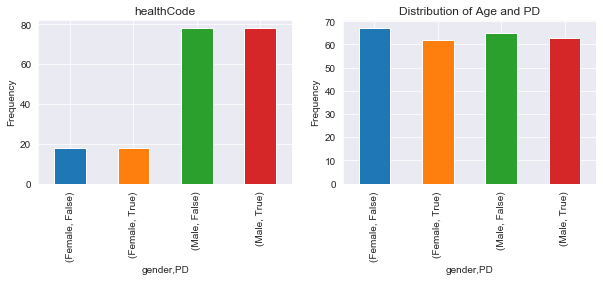

In [7]:
grouped = data.groupby(["gender", "PD"]).agg({"healthCode": lambda x: x.nunique(), "age": np.median})

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,3))


grouped["healthCode"].plot(kind = "bar", ax = axes[0],subplots=True, grid = True)
plt.title("Distribution of Genders and PD")
axes[0].set_ylabel("Frequency")

grouped["age"].plot(kind = "bar", ax = axes[1],subplots=True, grid = True)
plt.title("Distribution of Age and PD")
plt.ylabel("Frequency")


plt.show()

As data is approximately case-matched in terms of gender and their age based on the data above, statistical inferences on the pdkit features can be analyzed.

# Data Preparation

In [59]:
def normalize_dict(params, key):
    
    if params == "EMPTY FILEPATHS" or params == "NO ACCELEROMETER DATA":
        return np.NaN
    dict_ = ast.literal_eval(params)
    return dict_[key]

def normalize(data):
    for i in [feat for feat in data.columns if "features" in feat]:
        data["no_of_steps".format(i)] = data[i].apply(normalize_dict, 
                                                         key = "no_of_steps")
        data["median_freeze_index {}".format(i)] = data[i].apply(normalize_dict, 
                                                                 key = "median_freeze_index")
        data["count_freeze_index {}".format(i)] = data[i].apply(normalize_dict, 
                                                                key = "count_freeze_index")
        data["speed_of_gait {}".format(i)] = data[i].apply(normalize_dict, 
                                                           key = "speed_of_gait")
        data["gait_step_regularity {}".format(i)] = data[i].apply(normalize_dict, 
                                                                  key = "gait_step_regularity")
        data["gait_stride_regularity {}".format(i)] = data[i].apply(normalize_dict, 
                                                                    key = "gait_stride_regularity")
        data["gait_symmetry {}".format(i)] = data[i].apply(normalize_dict, 
                                                           key = "gait_symmetry")
        data["frequency_of_peaks {}".format(i)] = data[i].apply(normalize_dict, 
                                                                key = "frequency_of_peaks")
    return data

def plot_distribution(data):
    for i in [i for i in data.columns if "features" in i]:
        PD = data[data["PD"] == True][i].dropna()
        NONPD = data[data["PD"] == False][i].dropna()
        fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
        sns.distplot(PD, label = "PD", kde_kws={"shade": True}, hist = False, ax = axes[0])
        sns.distplot(NONPD, label = "NONPD", kde_kws={"shade": True}, hist = False, ax = axes[0])
        sns.boxplot(x = "PD", y = i, data = data, ax = axes[1], orient = "v", order = [True, False])
        axes[0].set_title("p-values: {}".format(ttest_ind(PD, NONPD)[1]))
        axes[0].grid()
        axes[1].grid()
        plt.show()

### Retrieving Data

In [9]:
walking_columns = [feat for feat in data.columns if ("features" in feat) 
                   and ("outbound" in feat or "return" in feat)]
balance_columns = [feat for feat in data.columns if ("features" in feat) 
                   and (feat not in walking_columns)]
data_no_feature = data[[feat for feat in data.columns if "features" 
                        not in feat]]
walking_data = data[[feat for feat in data.columns if (feat in walking_columns) 
                     or ("healthCode" in feat)]]
balance_data = data[[feat for feat in data.columns if (feat in balance_columns) 
                     or ("healthCode" in feat)]]

#### a. Walking Data (Outbound and Return Combined)

In [10]:
## get subset of data
temp = walking_data[["healthCode", "accel_return_features", "userAccel_return_features"]]
temp = temp.rename(columns = {"accel_return_features" : "accel_walking_features", 
                              "userAccel_return_features" : "userAccel_walking_features"})
walking_data = walking_data.rename(columns = {"accel_return_features" : "accel_walking_features", 
                              "userAccel_return_features" : "userAccel_walking_features"})

## Concatenate return and outbound data
temp = pd.concat([walking_data, temp], ignore_index = True)
walking_data = temp[["healthCode", "accel_walking_features", "userAccel_walking_features"]]

## clean empty files with zero values on returns
walking_data = walking_data[walking_data["accel_walking_features"] != "0"]

#### b. Normalize Dictionary in Data

In [11]:
#### normalize walking data
walking_data = normalize(walking_data)
balance_data = normalize(balance_data)
#### join with fact data
walking_data = pd.merge(walking_data, filtered_data, how = "left", on = "healthCode")
walking_data = walking_data.drop(["accel_walking_features", "userAccel_walking_features"], axis = 1)
balance_data = pd.merge(balance_data, filtered_data, how = "left", on = "healthCode")
balance_data = balance_data.drop(["accel_resting_features", "userAccel_resting_features"], axis = 1)

# EDA - RAW

Here are my experimental design processes:
1. Acceleration of return and outbound data will be combined into one dataset to assess test subjects movement
2. Resting will be assessed separately
3. Male and Females will be assessed separately to prevent cofounding effects on distribution
4. T-test between two distributions will be assessed to assess significant differences between PD and NON-PD
5. Conduct tests based on each healthCode performance (grouping by healthcodes)

Remarks:

- There are lots of empty plots due to how balance data is undetectable by the PDKit library, therefore all values are zeroed out.
- PD patient will be indicated as the color blue and NONPD as the color orange.

## 1. Walking Data All

In [60]:
walking_columns = ['no_of_steps accel_walking_features',
                    'median_freeze_index accel_walking_features',
                    'speed_of_gait accel_walking_features', 
                    'gait_step_regularity accel_walking_features',
                    'gait_stride_regularity accel_walking_features',
                    'gait_symmetry accel_walking_features',
                    'no_of_steps userAccel_walking_features',
                    'median_freeze_index userAccel_walking_features',
                    'speed_of_gait userAccel_walking_features',
                    'gait_step_regularity userAccel_walking_features',
                    'gait_stride_regularity userAccel_walking_features',
                    'gait_symmetry userAccel_walking_features',
                    'PD']

balance_columns = ['median_freeze_index accel_resting_features',
                    'speed_of_gait accel_resting_features',
                    'count_freeze_index userAccel_resting_features',
                    'median_freeze_index userAccel_resting_features',
                    'speed_of_gait userAccel_resting_features',
                    'PD']

#### Analysis on Male Subjects

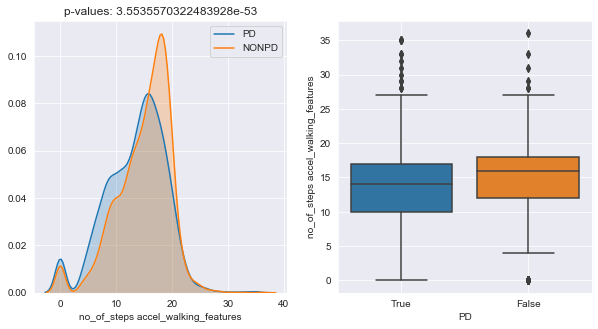

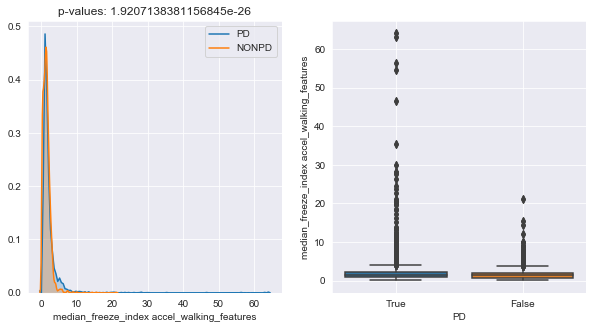

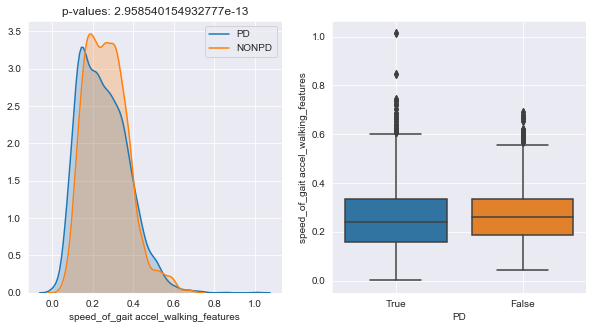

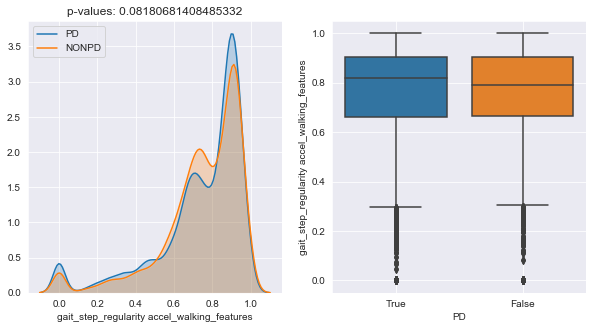

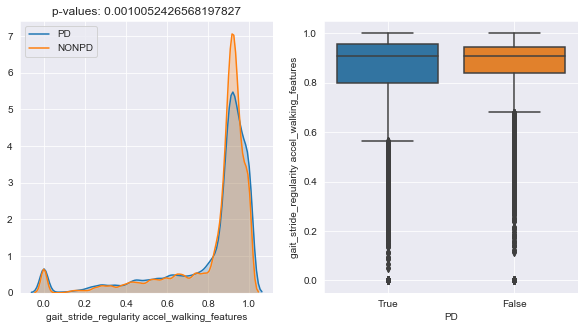

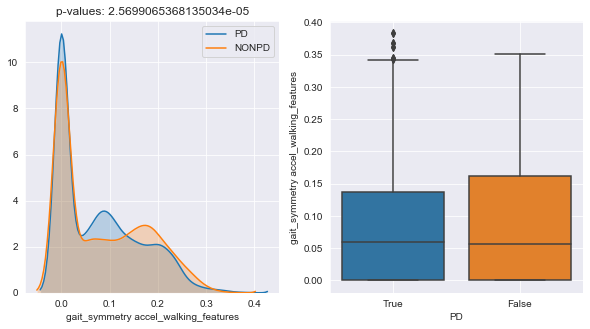

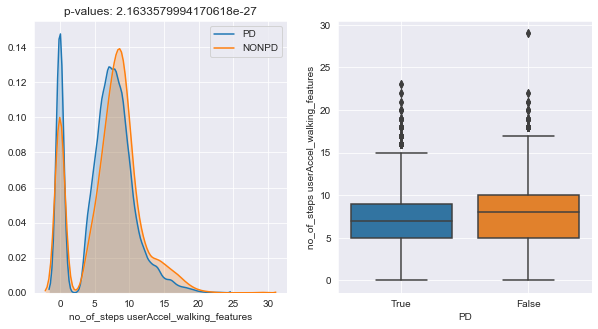

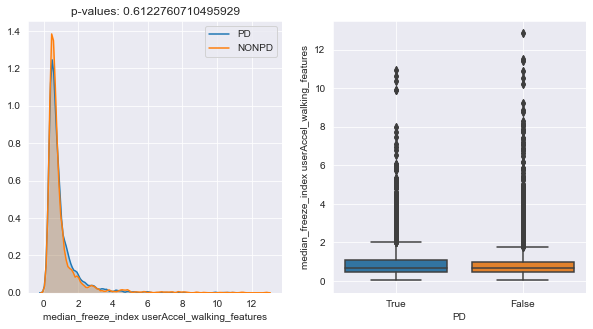

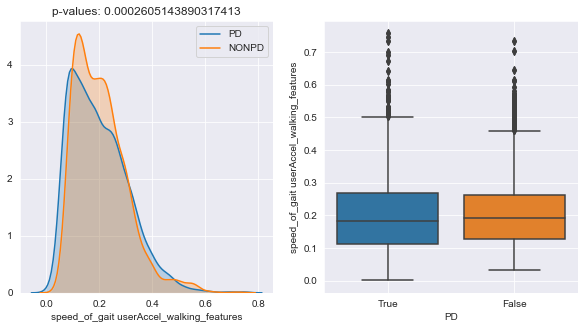

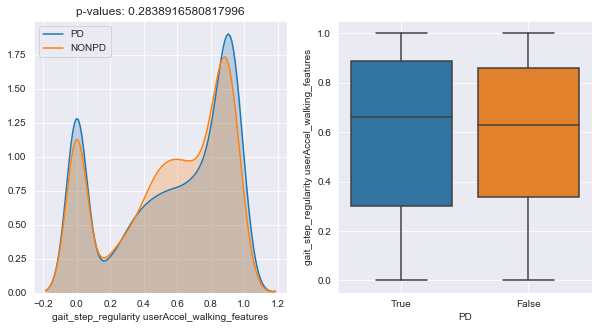

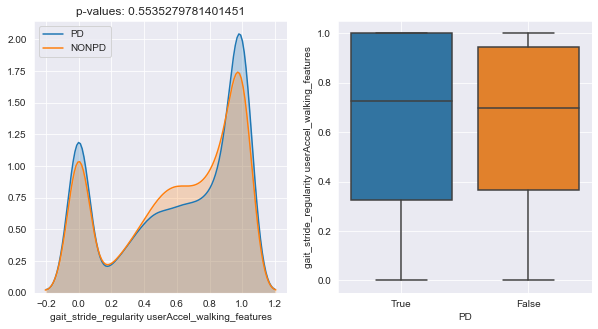

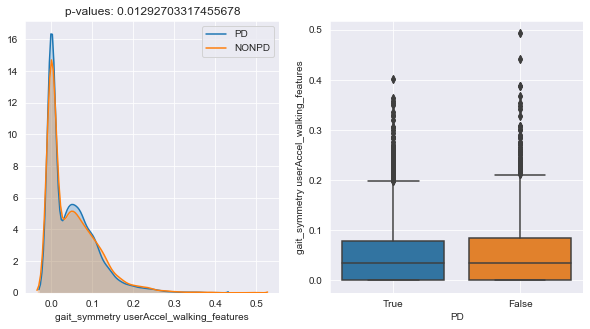

In [61]:
plot_distribution(walking_data[walking_data["gender"]== "Male"][walking_columns])

#### Analysis on Female Subjects

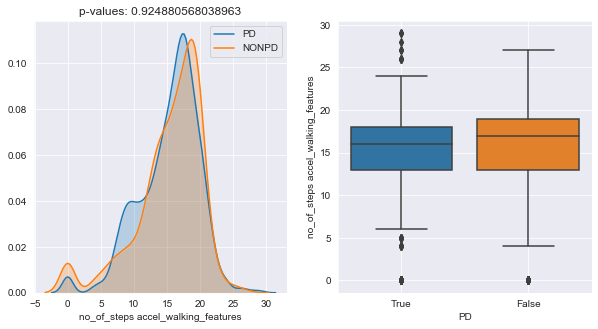

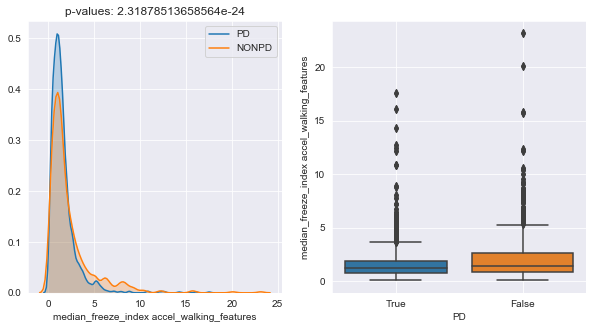

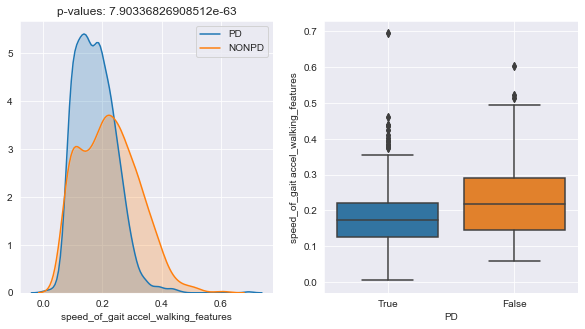

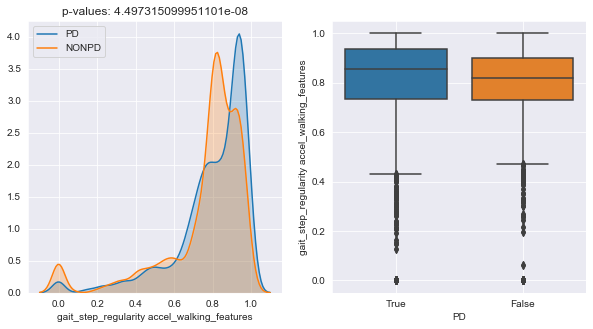

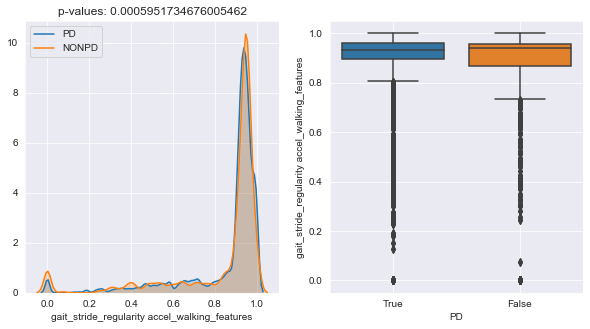

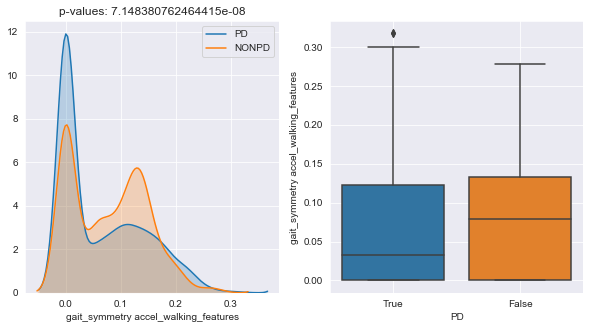

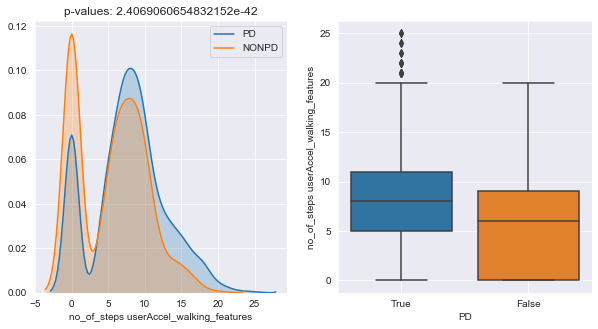

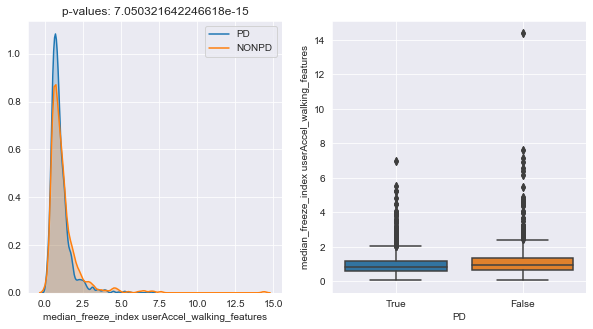

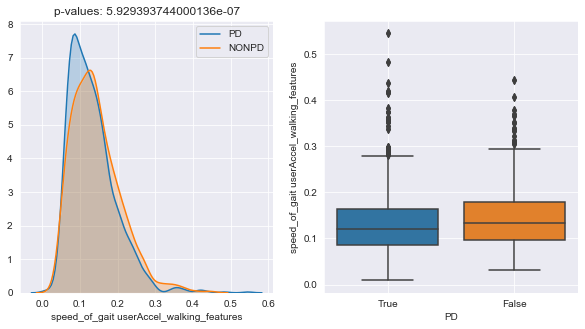

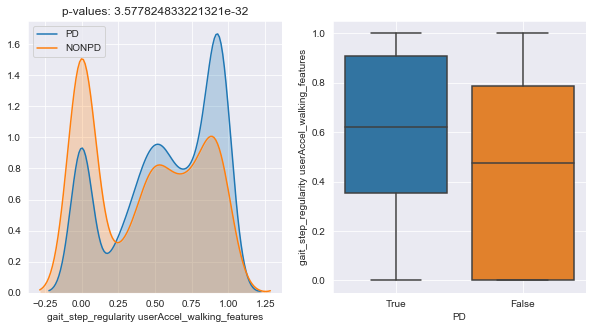

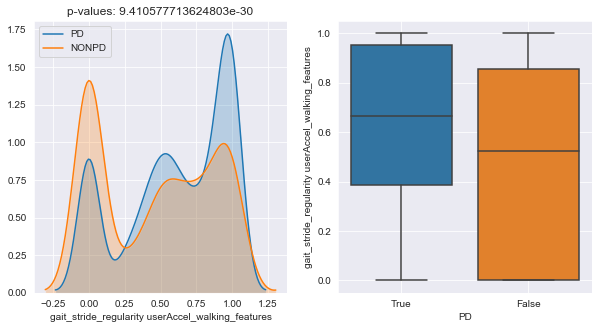

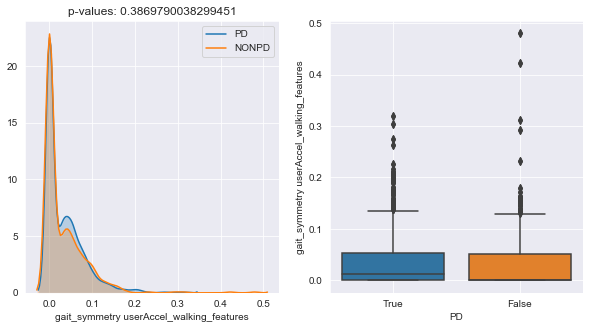

In [43]:
plot_distribution(walking_data[walking_data["gender"]== "Female"][walking_columns])

## 2. Balance Data All

#### Analysis on Males

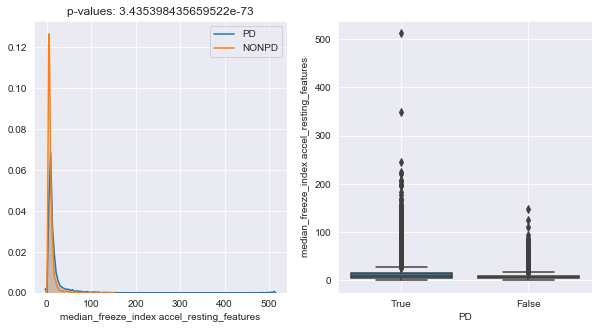

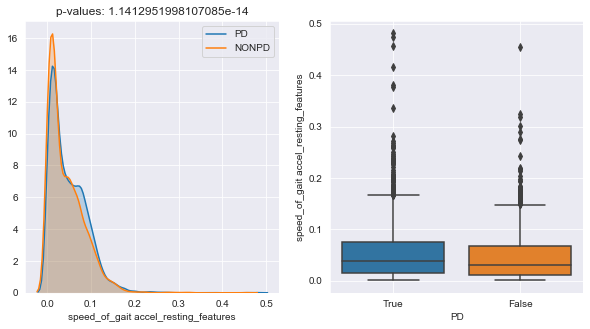

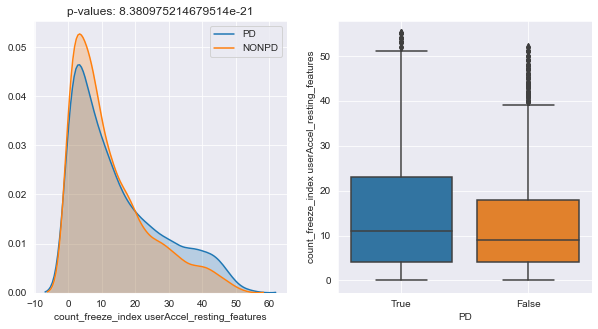

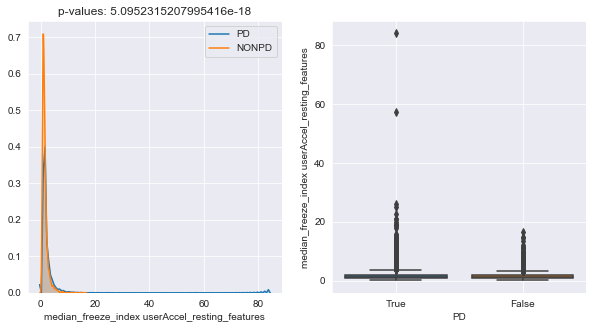

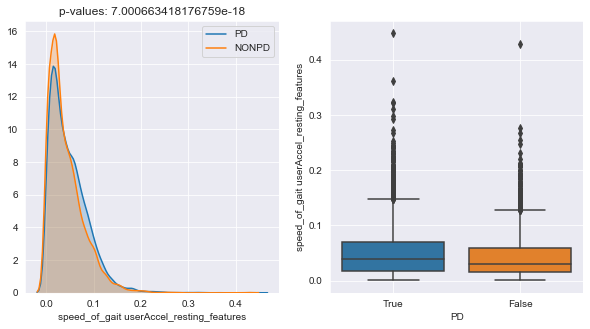

In [62]:
plot_distribution(balance_data[balance_data["gender"]== "Male"][balance_columns])

#### Analysis on Females

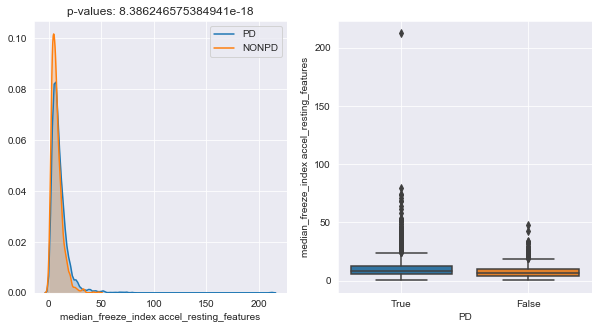

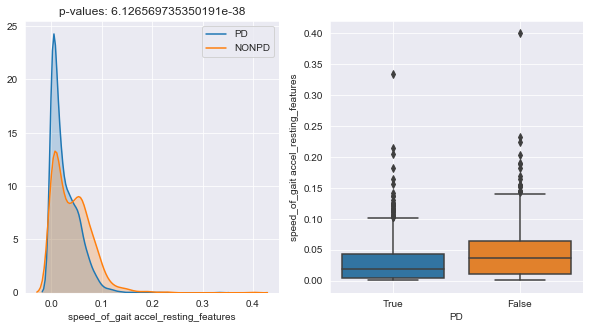

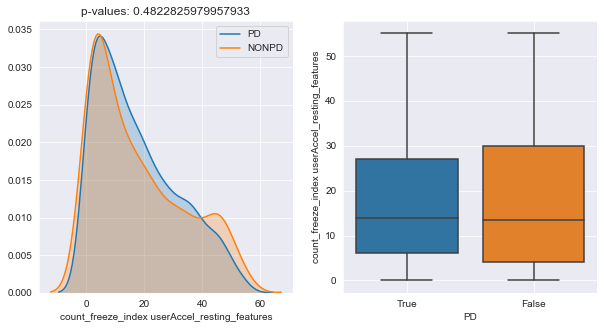

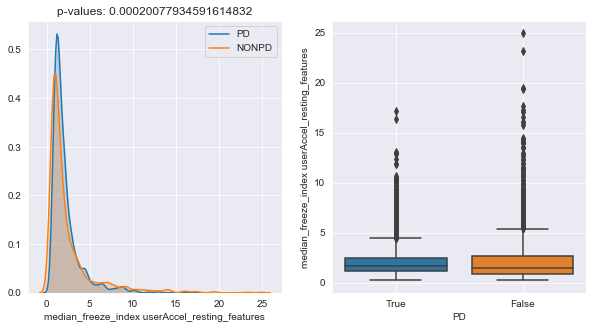

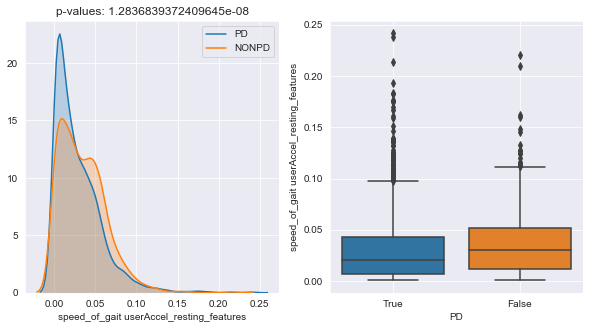

In [63]:
plot_distribution(balance_data[balance_data["gender"]== "Female"][balance_columns])

## 3. Analysis per HealthCode Data

#### Walking Males Subject

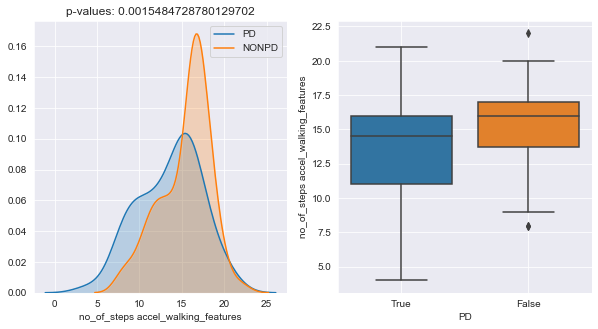

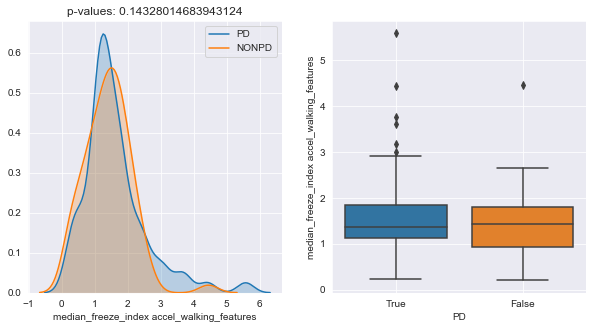

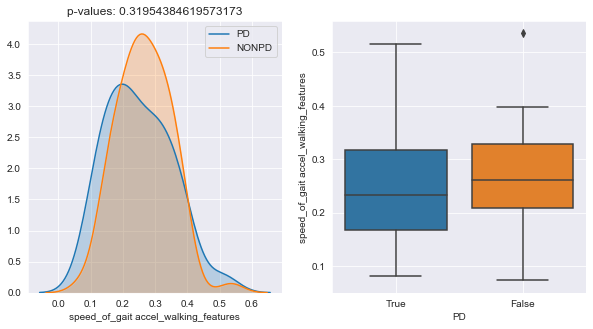

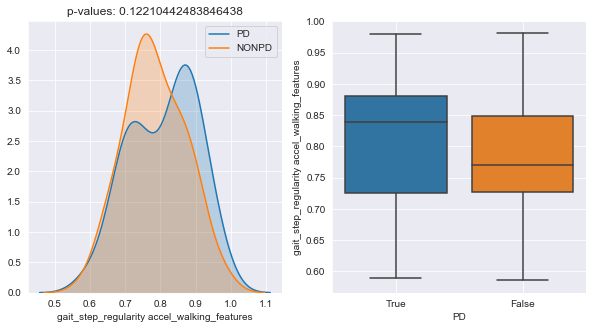

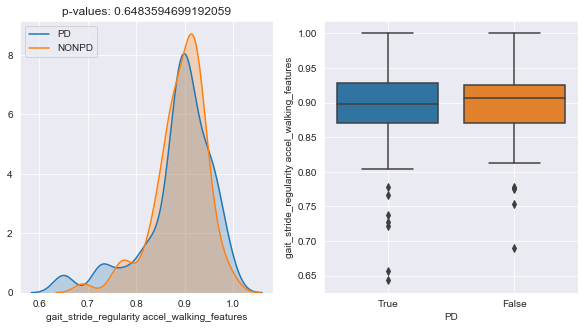

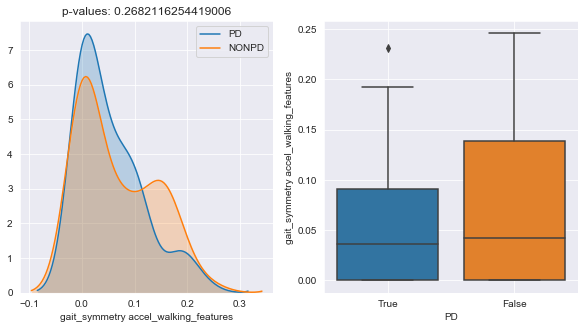

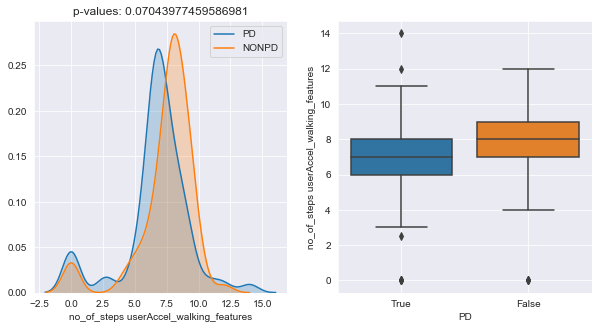

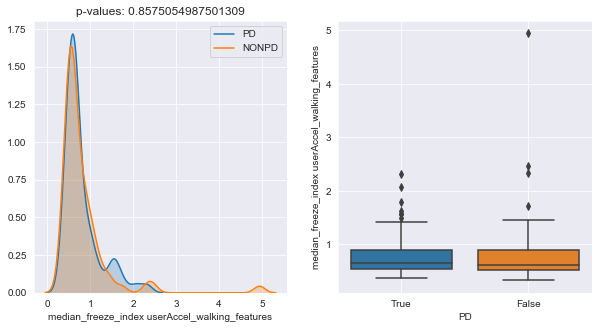

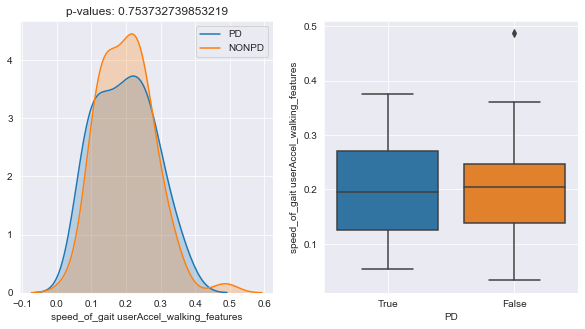

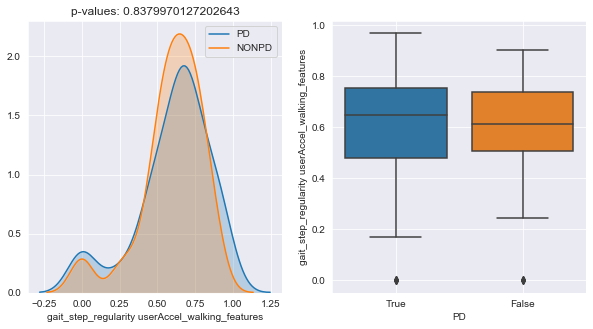

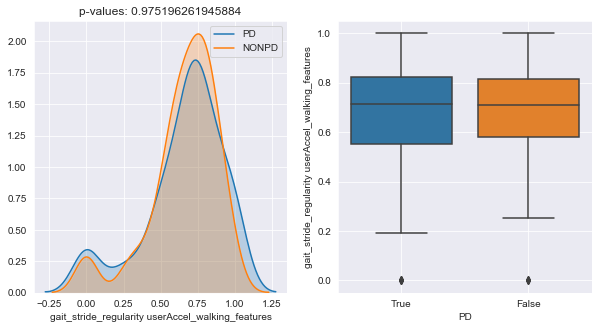

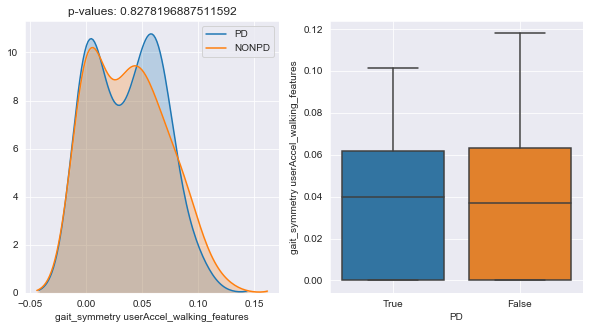

In [64]:
data = walking_data[walking_data["gender"]== "Male"]
grouped_data = data.groupby("healthCode").median()
plot_distribution(grouped_data[walking_columns])

#### Walking Females Subject

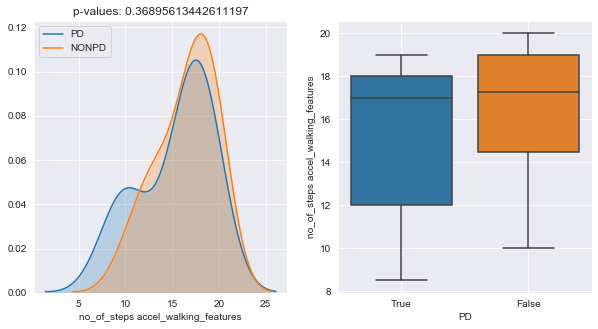

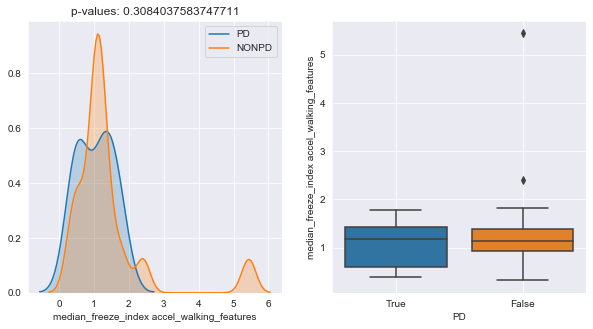

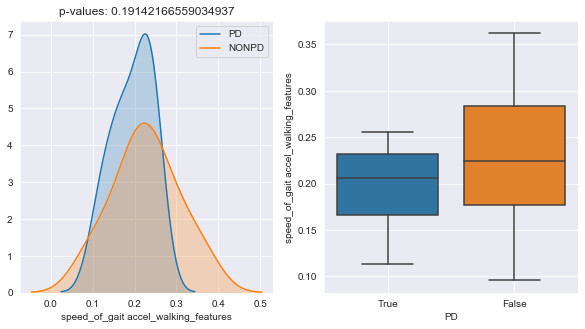

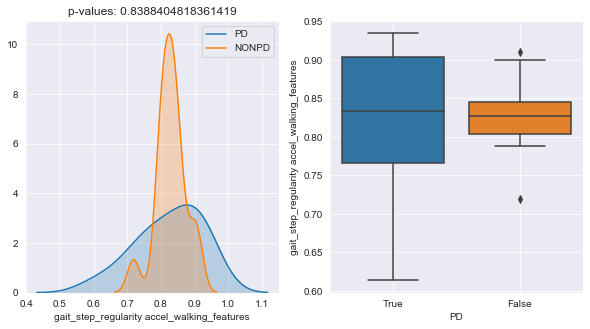

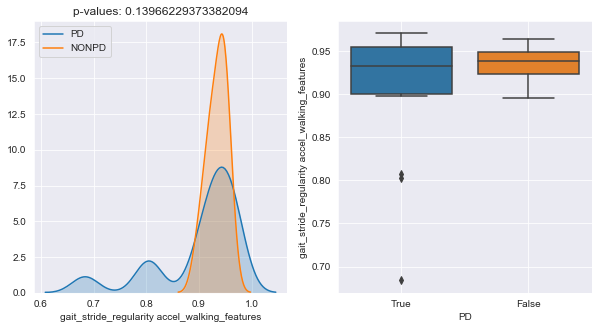

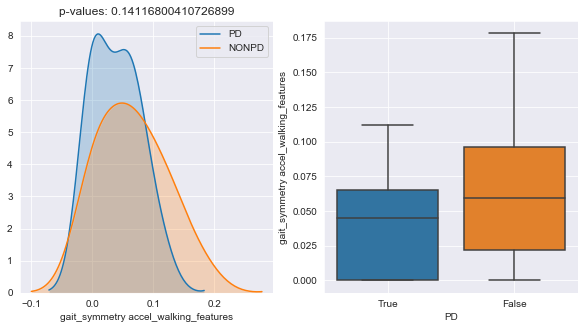

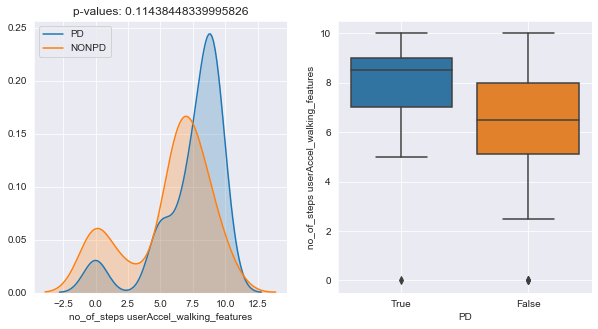

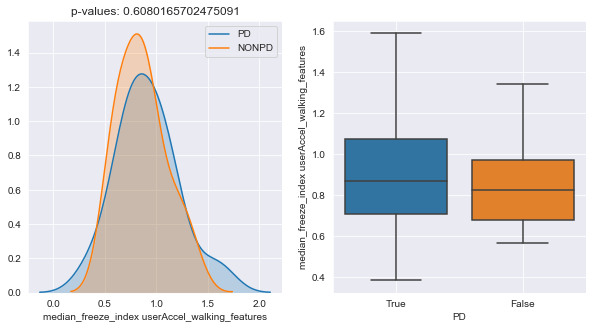

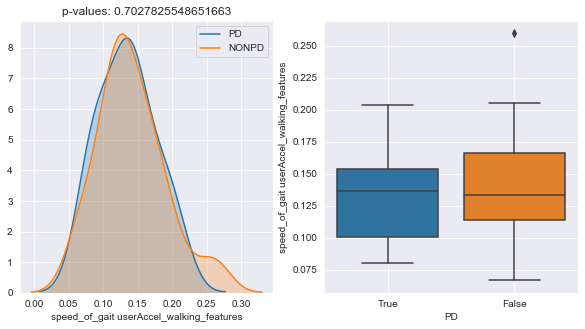

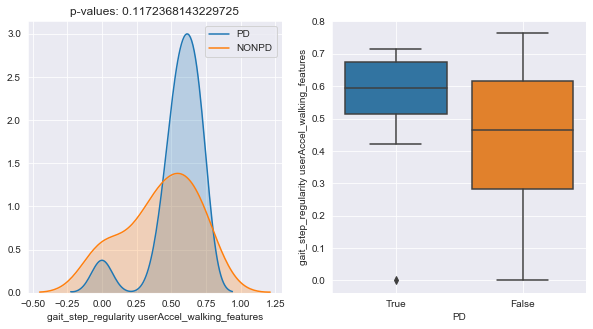

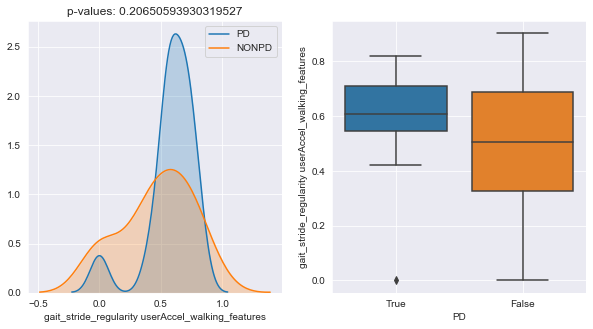

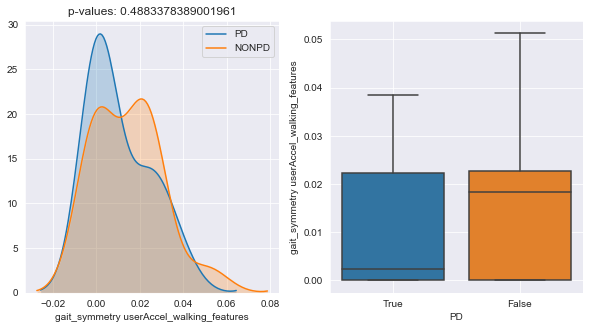

In [66]:
data = walking_data[walking_data["gender"]== "Female"]
grouped_data = data.groupby("healthCode").median()
plot_distribution(grouped_data[walking_columns])

#### Balance Male Subject

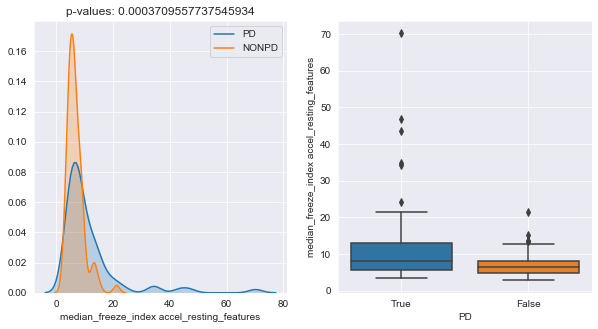

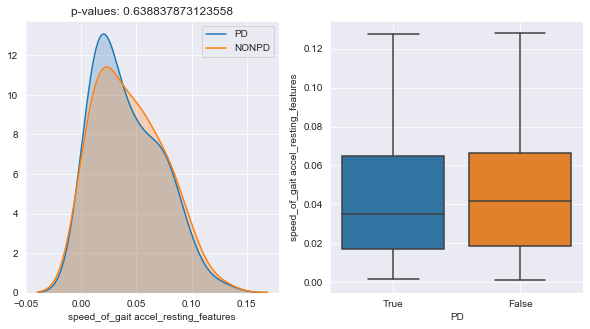

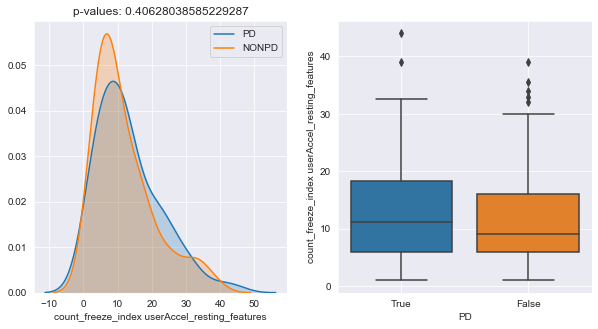

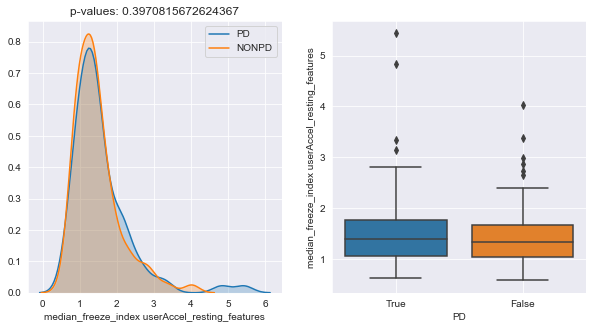

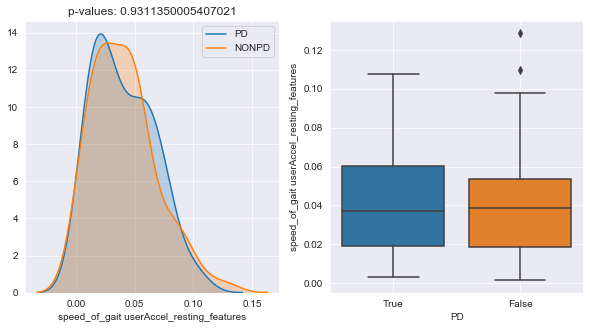

In [53]:
data = balance_data[balance_data["gender"]== "Male"]
grouped_data = data.groupby("healthCode").median()
plot_distribution(grouped_data[balance_columns])

#### Balance Female Subject

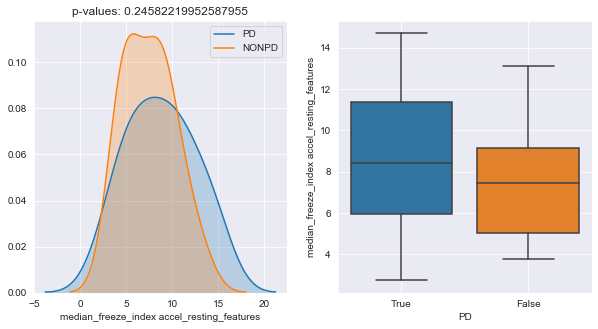

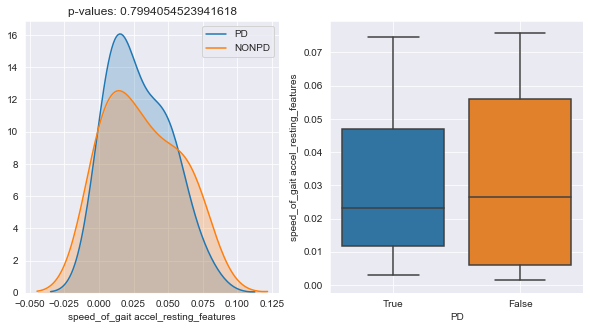

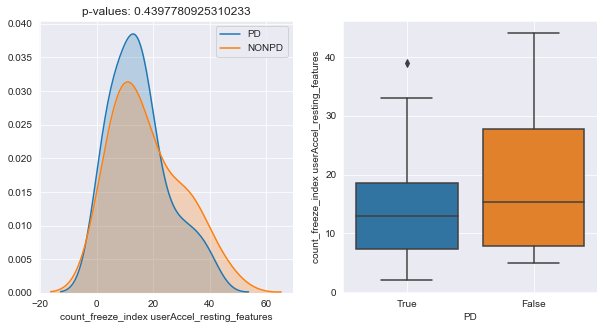

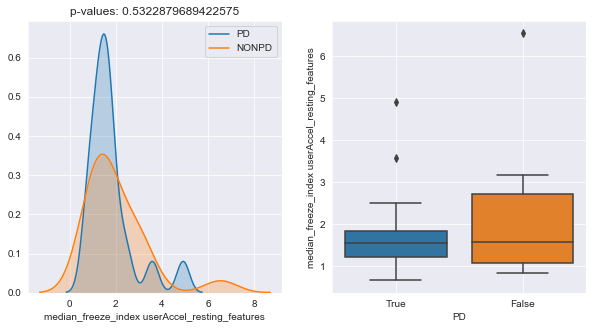

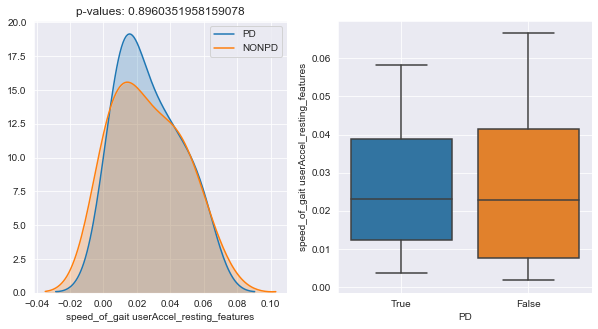

In [56]:
data = balance_data[balance_data["gender"]== "Female"]
grouped_data = data.groupby("healthCode").median()
plot_distribution(grouped_data[balance_columns])